# Modelling RfQs in Dealer to Client Markets

## Generative models for the request for quote activity

### Simulation of RfQs arrival and client attrition

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from collections import deque

def run_simulation(N_clients=50,
                   T=200,
                   reservation_price_mean=100,
                   reservation_price_std_pct=0.1,
                   lambda_mean=1,
                   lambda_std=0.05,
                   prior_mean=60,
                   prior_std=10,
                   reservation_price_noise_std=None,
                   hit_rate_target=0.4,
                   window_size=10,
                   attrition_threshold=0.1):

    """
    Simulate RFQ interactions with Bayesian quantile pricing and client attrition.
    Clients stop trading if their moving-average hit rate over `window_size` days falls below `attrition_threshold`.

    Returns:
        rfq_df: DataFrame of RfQ events
        active_history: list of active client counts per day
        activity_matrix: binary DataFrame of daily activity (clients x days)
    """
    np.random.seed(42)
    # Generate distribution of reservation prices for the segment of clients
    reservation_prices = np.random.normal(reservation_price_mean,
                                  reservation_price_mean * reservation_price_std_pct,
                                  N_clients)
    # Reservation prices are noisy given potential changing market conditions
    res_price_noise_std = res_price_noise_std or (fair_price * reservation_price_std_pct * 2)
    res_price_noise_var = res_price_noise_std**2
    # Generate distribution of RfQ intensities for the segment of clients
    lambdas = np.abs(np.random.normal(lambda_mean, lambda_std, N_clients))
    clients_posterior = {i: {'mean': prior_mean, 'var': prior_std**2,
                             'n': 0, 'sum_obs': 0.0}
                         for i in range(N_clients)}
    z = norm.ppf(1 - hit_rate_target)
    active = np.ones(N_clients, dtype=bool)
    # Track per-client active status at end of each day
    active_flags = np.zeros((T, N_clients), dtype=bool)
    daily_history = [deque(maxlen=window_size) for _ in range(N_clients)]
    active_history = []
    records = []
    Y = np.zeros((T, N_clients), dtype=int)
    for t in range(T):
        daily_hits = np.zeros(N_clients, dtype=int)
        daily_reqs = np.zeros(N_clients, dtype=int)
        for i in range(N_clients):
            if not active[i]: continue
            n_rfq = poisson.rvs(lambdas[i])
            if n_rfq > 0: Y[t,i] = 1
            for _ in range(n_rfq):
                post = clients_posterior[i]
                price = max(0.0, post['mean'] + np.sqrt(post['var'] + res_price_noise_var) * z)
                r = norm.rvs(reservation_prices[i], res_price_noise_std)
                # Trading happens when price offered is lower than the reservation price
                hit = price <= r
                daily_reqs[i] += 1; daily_hits[i] += int(hit)
                # The dealer updates the estimation of the reservation price of the client
                post['n'] += 1; post['sum_obs'] += r
                post_var = 1/(1/prior_std**2 + post['n']/res_price_noise_var)
                post['var'] = post_var
                post['mean'] = post_var*(prior_mean/prior_std**2 + post['sum_obs']/res_price_noise_var)
                records.append({'time': t, 'client_id': i, 'price': price, 'hit': hit})
        for i in range(N_clients):
            if not active[i] or daily_reqs[i]==0: continue
            rate = daily_hits[i]/daily_reqs[i]
            daily_history[i].append(rate)
            # A client stops sending RfQs to the dealer if the hit & miss is too low
            if len(daily_history[i])==window_size and np.mean(daily_history[i])<attrition_threshold:
                active[i] = False
        active_history.append(active.sum())
        active_flags[t, :] = active.copy()
    rfq_df = pd.DataFrame(records)
    activity = pd.DataFrame(Y, columns=[f'client_{i}' for i in range(N_clients)])
    active_df = pd.DataFrame(active_flags, columns=[f'client_{i}' for i in range(N_clients)])
    return rfq_df, active_history, activity, active_df


In [ ]:
from scipy.special import betaln
from scipy.optimize import minimize

# ----------------------
# Segment-level Model
# ----------------------
def estimate_segment_params(activity_matrix):
    def log_marginal_likelihood(D, alpha, beta, gamma, delta):
        n, x = len(D), D.sum()
        last = np.where(D==1)[0]
        r = n - (last[-1]+1) if last.size>0 else n
        logA = (betaln(alpha+x, beta+n-x)-betaln(alpha,beta)
                +betaln(gamma, delta+n)-betaln(gamma,delta))
        logB = [(betaln(alpha+x, beta+n-x-i)-betaln(alpha,beta)
                 +betaln(gamma+1, delta+n-i)-betaln(gamma,delta))
                for i in range(1, r+1)]
        mags = [logA] + logB; m_max = max(mags)
        return m_max + np.log(sum(np.exp(m - m_max) for m in mags))
    def neg_ll(params):
        alpha, beta, gamma, delta = np.exp(params)
        return -sum(log_marginal_likelihood(activity_matrix.iloc[:end, j].values,
                                             alpha, beta, gamma, delta)
                    for j in range(activity_matrix.shape[1])
                    for end in [activity_matrix.iloc[:,:].values.shape[0]])
    res = minimize(neg_ll, np.log([1,1,1,1]), method='L-BFGS-B', bounds=[(-5,5)]*4)
    return np.exp(res.x)

def attrition_probability(D, alpha, beta, gamma, delta):
    n, x = len(D), D.sum()
    last = np.where(D==1)[0]
    r = n - (last[-1]+1) if last.size>0 else n
    logA = (betaln(alpha+x, beta+n-x)-betaln(alpha,beta)
            +betaln(gamma, delta+n)-betaln(gamma,delta))
    logB = [(betaln(alpha+x, beta+n-x-i)-betaln(alpha,beta)
             +betaln(gamma+1, delta+n-i)-betaln(gamma,delta))
            for i in range(1, r+1)]
    mags = [logA] + logB; m_max = max(mags)
    logL = m_max + np.log(sum(np.exp(m - m_max) for m in mags))
    P_active = np.exp(logA - logL)
    return 1 - P_active


Params: α=148.41, β=85.31, γ=0.08, δ=148.41
Confusion Matrix:
  TN=4365, FP=0, FN=76, TP=559
Accuracy : 0.9848
Precision: 1.0000
Recall   : 0.8803
AUC      : 0.9884


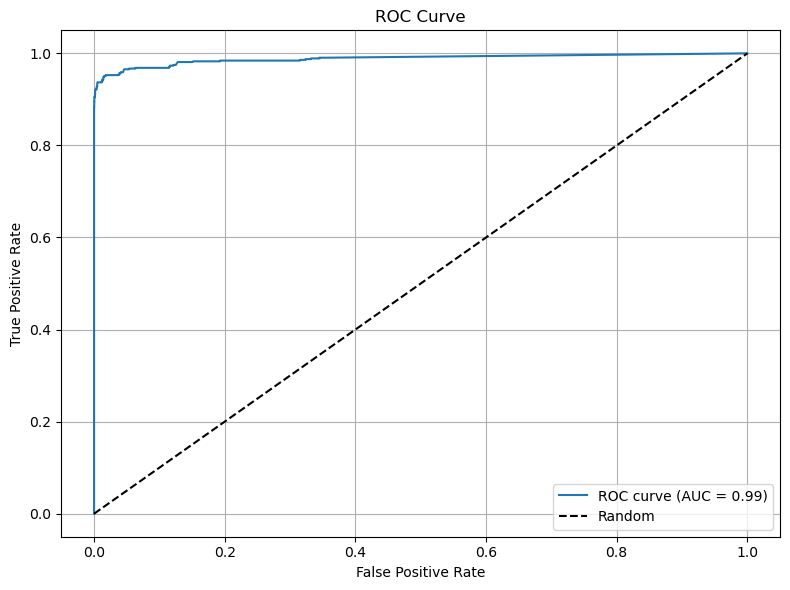

In [255]:

from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score,
    roc_curve, auc
)

# ----------------------
# Workflow: Simulate, Train, Test
# ----------------------
T_train, T_test = 100, 100
rfq_all, active_all, Y_all, active_df = run_simulation(T=T_train+T_test)

Y_train = Y_all.iloc[:T_train].reset_index(drop=True)
Y_test  = Y_all.iloc[T_train:].reset_index(drop=True)
rfq_test = rfq_all[rfq_all['time']>=T_train].copy()
rfq_test['time'] -= T_train
active_test = active_all[T_train:]

alpha, beta, gamma, delta = estimate_segment_params(Y_train)
print(f"Params: α={alpha:.2f}, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}")

# ----------------------
# Risk Scoring
# ----------------------
risk_records = []
for j in range(Y_test.shape[1]):
    hist = []
    for t in range(T_test):
        hist.append(Y_test.iloc[t, j])
        D = np.array(hist, dtype=int)
        p_inact = attrition_probability(D, alpha, beta, gamma, delta)
        risk_records.append({
            'time': t,
            'client_id': j,
            'p_inactive': p_inact,
            'alert': p_inact > 0.5  # thresholded prediction
        })

risk_df = pd.DataFrame(risk_records)

# Label inactivity
risk_df['inactive'] = risk_df.apply(
    lambda r: not active_df.loc[r['time'] + T_train, f'client_{r["client_id"]}'],
    axis=1
)

# ----------------------
# Evaluation Metrics
# ----------------------

# Ground truth and predictions
y_true   = risk_df['inactive']
y_pred   = risk_df['alert']           # at 0.5 threshold
y_scores = risk_df['p_inactive']      # raw probabilities

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("Confusion Matrix:")
print(f"  TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Accuracy, Precision, Recall at 0.5
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

# ROC curve & AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print(f"AUC      : {roc_auc:.4f}")

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


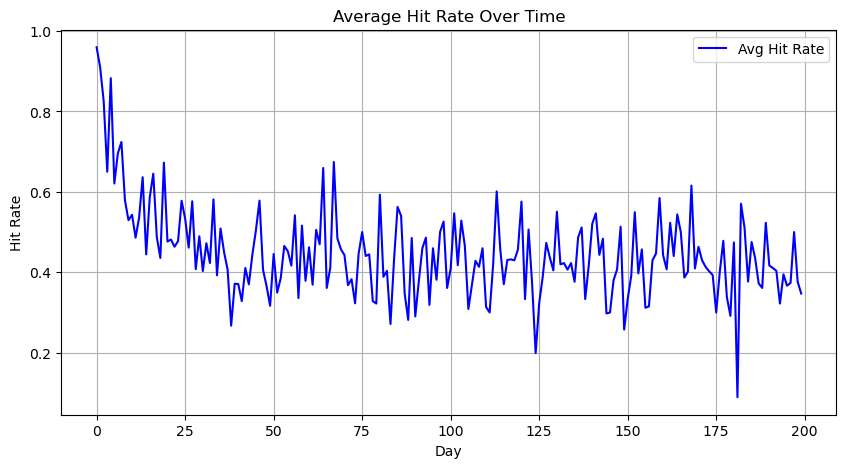

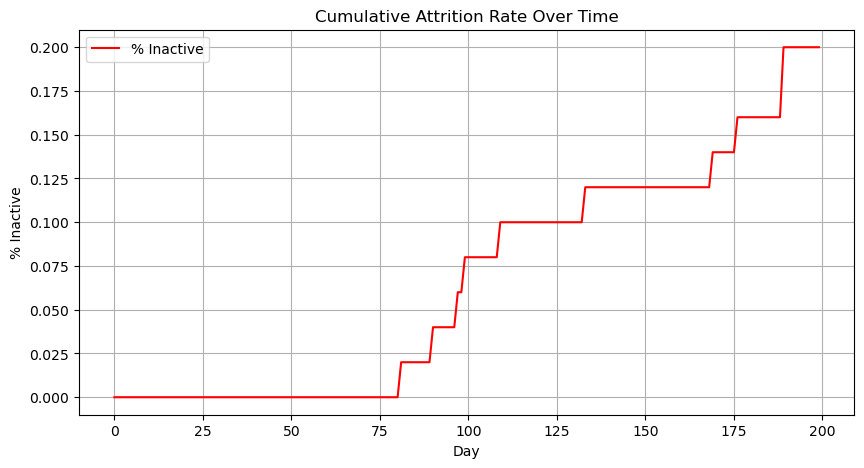

In [192]:
# ----------------------
# Plots: Hit Rate & Attrition Over Full Simulation
# ----------------------
# Active-client hit rate over time
hit_rate_active = []
days = np.arange(T_tot)
for t in days:
    act_clients = active_df.iloc[t]
    active_ids = [int(col.split('_')[1]) for col, flag in act_clients.items() if flag]
    daily = rfq_all[rfq_all['time'] == t]
    rates = []
    for cid in active_ids:
        cr = daily[daily['client_id'] == cid]
        if not cr.empty:
            rates.append(cr['hit'].mean())
    hit_rate_active.append(np.mean(rates) if rates else np.nan)

plt.figure(figsize=(10,5))
plt.plot(days, hit_rate_active, label='Avg Hit Rate', color='blue')
plt.title('Average Hit Rate Over Time')
plt.xlabel('Day'); plt.ylabel('Hit Rate'); plt.grid(True); plt.legend()

# Attrition rate over time
attr_rate = [(Y_all.shape[1] - x) / Y_all.shape[1] for x in active_all]
plt.figure(figsize=(10,5))
plt.plot(days, attr_rate, label='% Inactive', color='red')
plt.title('Cumulative Attrition Rate Over Time')
plt.xlabel('Day'); plt.ylabel('% Inactive'); plt.grid(True); plt.legend()


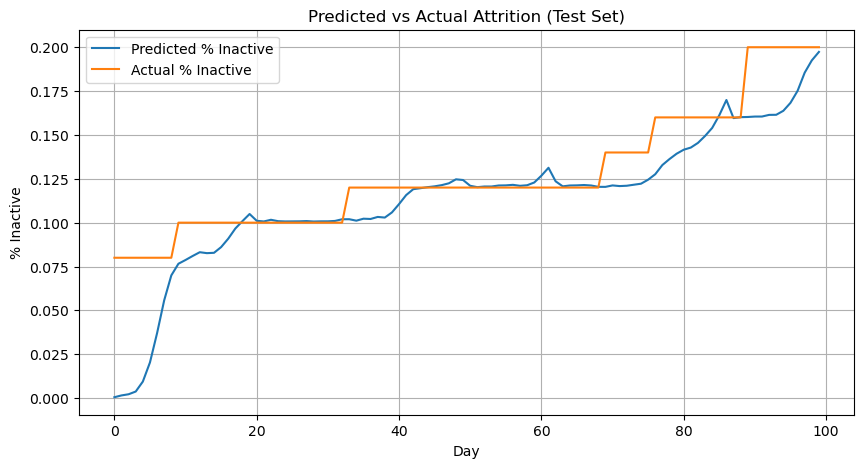

In [193]:
# ----------------------
# Model Fit Visualization
# ----------------------
# Compare predicted attrition vs actual on test
pred_rate = risk_df.groupby('time')['p_inactive'].mean()
actual_rate = [(N_clients-x)/N_clients for x in active_test]
plt.figure(figsize=(10,5))
plt.plot(pred_rate.index, pred_rate.values, label='Predicted % Inactive')
plt.plot(actual_rate, label='Actual % Inactive')
plt.title('Predicted vs Actual Attrition (Test Set)')
plt.xlabel('Day'); plt.ylabel('% Inactive'); plt.legend(); plt.grid(True)

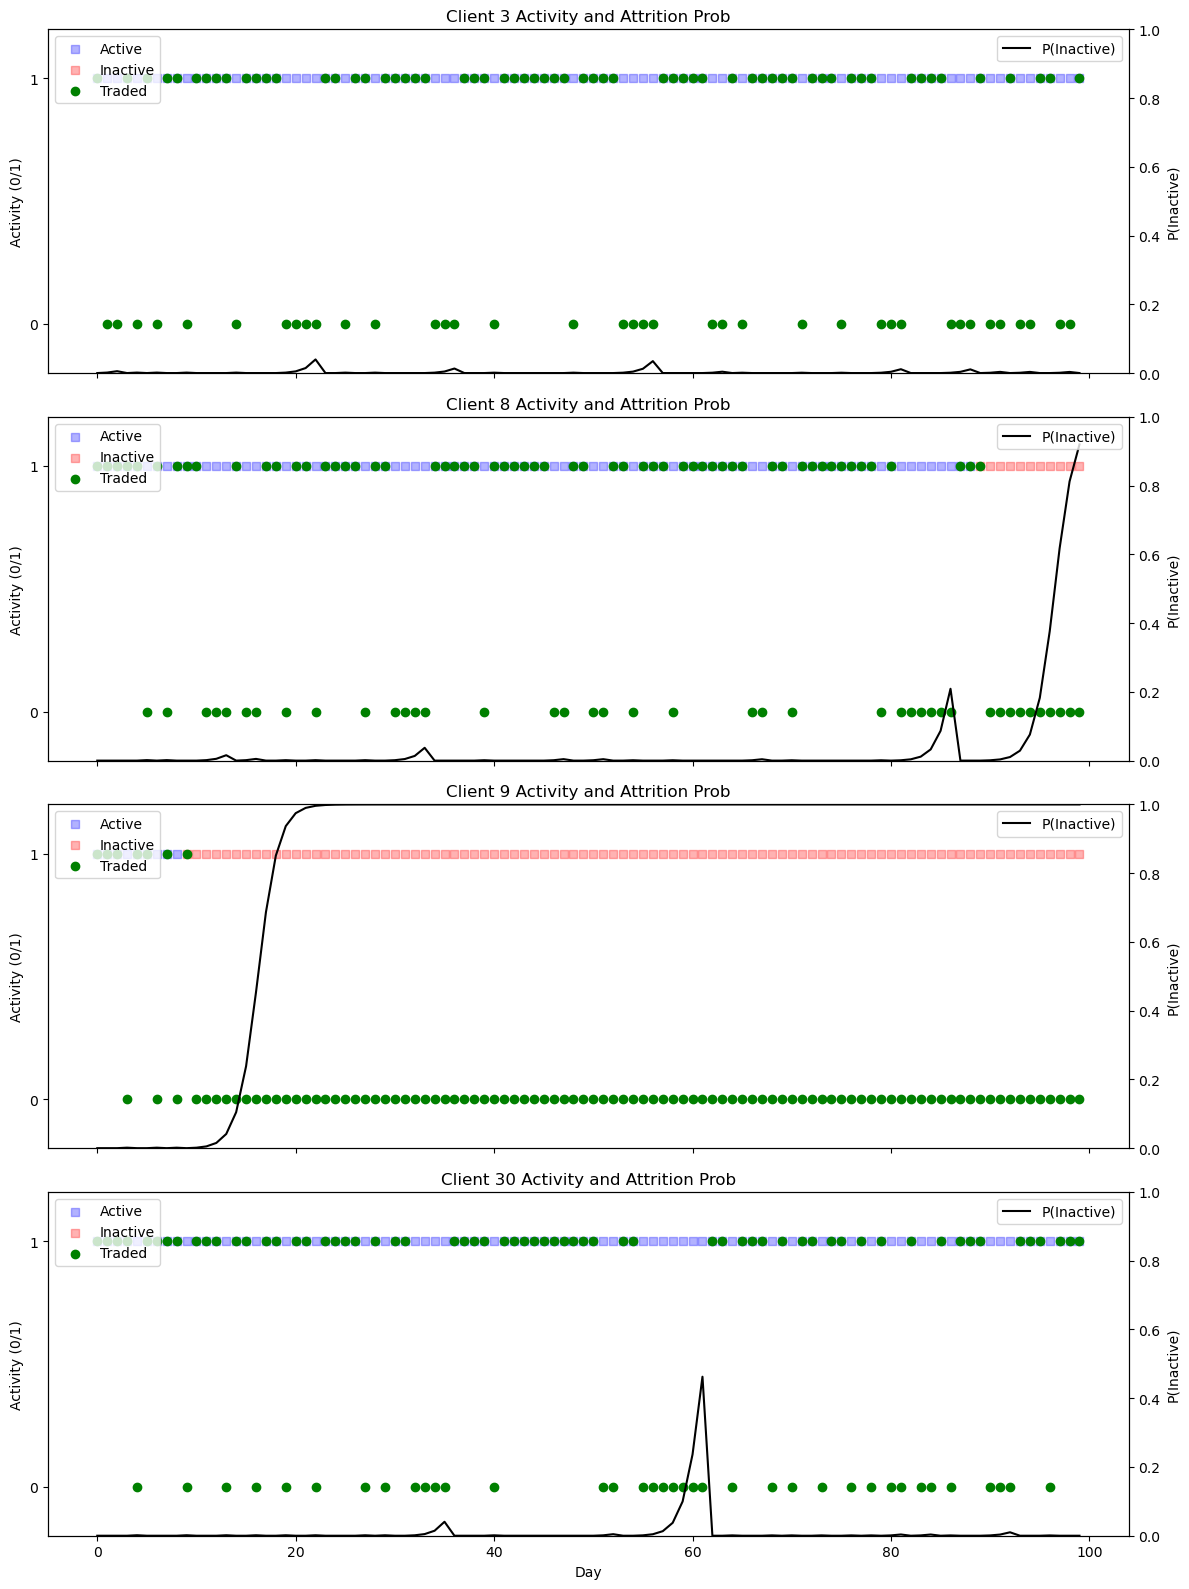

In [257]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Function: Plot Clients by ID (single figure with subplots)
# ----------------------
def plot_clients_subplots(client_ids):
    """
    For each client in client_ids, create a subplot in one figure:
      - Left y-axis: active (blue=active, red=inactive) and trading days (green), with numeric ticks (0/1)
      - Right y-axis: attrition probability over time
      - Separate legends: left for 'Active', 'Inactive', 'Traded'; right for 'P(Inactive)'
      - Title of each subplot shows the client ID
    """
    n = len(client_ids)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 4*n), sharex=True)
    if n == 1:
        axes = [axes]
        
    days = np.arange(T_test)

    for ax1, cid in zip(axes, client_ids):
        # gather P(inactive) values
        p_vals = [
            risk_df.loc[
                (risk_df['client_id'] == cid) & (risk_df['time'] == t),
                'p_inactive'
            ].item()
            for t in days
        ]
        # latent active flags and trading days
        active_flag = active_df[T_train:][f'client_{cid}'].values
        trade_days  = Y_test.iloc[:, cid]

        # Left axis: Active vs Inactive
        idx_active   = days[active_flag]
        idx_inactive = days[~active_flag]
        h_active   = ax1.scatter(idx_active,   [1]*len(idx_active),   c='blue', marker='s', alpha=0.3, label='Active')
        h_inactive = ax1.scatter(idx_inactive, [1]*len(idx_inactive), c='red',  marker='s', alpha=0.3, label='Inactive')
        # Left axis: actual trades (0 or 1)
        h_trade = ax1.scatter(trade_days.index, trade_days.values,
                              c='green', marker='o', label='Traded')

        # Set numeric ticks on left y-axis
        ax1.set_ylim(-0.2, 1.2)
        ax1.set_yticks([0, 1])
        ax1.set_ylabel('Activity (0/1)')
        ax1.set_title(f'Client {cid} Activity and Attrition Prob')

        # Left-axis legend
        ax1.legend(handles=[h_active, h_inactive, h_trade],
                   labels=['Active', 'Inactive', 'Traded'],
                   loc='upper left')

        # Right axis: P(Inactive)
        ax2 = ax1.twinx()
        h_prob, = ax2.plot(days, p_vals, c='black', label='P(Inactive)')
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('P(Inactive)')

        # Right-axis legend
        ax2.legend(handles=[h_prob], loc='upper right')

    axes[-1].set_xlabel('Day')
    plt.tight_layout()
    plt.show()

# Example: plot select clients in one figure
#plot_clients_subplots([3, 8, 9, 18])
plot_clients_subplots([3, 8, 9, 30])


### Simulation of client abnormal behavior

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from collections import deque

def run_simulation(N_clients=50,
                   T=200,
                   reservation_price_mean=100,
                   reservation_price_std_pct=0.1,
                   lambda_mean=1,
                   lambda_std=0.05,
                   prior_mean=60,
                   prior_std=10,
                   reservation_price_noise_std=None,
                   discount_trigger_pct=0.35,  # trigger threshold: 0.5 means 50% lower
                   boosted_rate_factor = 10,
                   hit_rate_target=0.4,
                   window_size=10,
                   attrition_threshold=0.1,
                   random_seed=42):

    """
    Simulate RFQ interactions with Bayesian quantile pricing and client attrition.
    Adds a mechanism: if a client gets a quote at least `discount_trigger_pct` below their reservation price,
    they double their RFQ rate until the dealer quotes above their reservation price.
    """

    np.random.seed(random_seed)

    # Generate distribution of reservation prices
    reservation_prices = np.random.normal(reservation_price_mean,
                                          reservation_price_mean * reservation_price_std_pct,
                                          N_clients)

    # Noise in reservation prices
    fair_price = reservation_price_mean
    res_price_noise_std = reservation_price_noise_std or (fair_price * reservation_price_std_pct * 2)
    res_price_noise_var = res_price_noise_std ** 2

    # Base RfQ intensities
    lambdas = np.abs(np.random.normal(lambda_mean, lambda_std, N_clients))
    base_lambdas = lambdas.copy()  # store for reset later

    # Posterior beliefs
    clients_posterior = {i: {'mean': prior_mean, 'var': prior_std ** 2,
                             'n': 0, 'sum_obs': 0.0}
                         for i in range(N_clients)}

    z = norm.ppf(1 - hit_rate_target)
    active = np.ones(N_clients, dtype=bool)

    # Flags for tracking "boosted" mode
    boosted = np.zeros(N_clients, dtype=bool)

    # Track daily active/boosted status
    active_flags = np.zeros((T, N_clients), dtype=bool)
    boosted_flags = np.zeros((T, N_clients), dtype=bool)

    daily_history = [deque(maxlen=window_size) for _ in range(N_clients)]
    active_history = []
    records = []
    Y = np.zeros((T, N_clients), dtype=int)  # binary: whether client sent at least one RFQ that day

    for t in range(T):
        daily_hits = np.zeros(N_clients, dtype=int)
        daily_reqs = np.zeros(N_clients, dtype=int)

        for i in range(N_clients):
            if not active[i]:
                continue

            n_rfq = poisson.rvs(lambdas[i])
            if n_rfq > 0:
                Y[t, i] = 1

            for _ in range(n_rfq):
                post = clients_posterior[i]
                price = max(0.0, post['mean'] + np.sqrt(post['var'] + res_price_noise_var) * z)
                r = norm.rvs(reservation_prices[i], res_price_noise_std)

                # Trading happens when price <= reservation price
                hit = price <= r
                daily_reqs[i] += 1
                daily_hits[i] += int(hit)

                # Check discount trigger
                if price <= (1 - discount_trigger_pct) * r:
                    boosted[i] = True
                    lambdas[i] = base_lambdas[i] * boosted_rate_factor
                elif boosted[i] and price > r / (1-discount_trigger_pct):
                    boosted[i] = False
                    lambdas[i] = base_lambdas[i]

                # Update posterior belief
                post['n'] += 1
                post['sum_obs'] += r
                post_var = 1 / (1 / (prior_std ** 2) + post['n'] / res_price_noise_var)
                post['var'] = post_var
                post['mean'] = post_var * (prior_mean / (prior_std ** 2) +
                                           post['sum_obs'] / res_price_noise_var)

                records.append({'time': t,
                                'client_id': i,
                                'price': price,
                                'reservation': r,
                                'hit': hit,
                                'boosted': boosted[i]})

        # Update attrition status
        for i in range(N_clients):
            if not active[i] or daily_reqs[i] == 0:
                continue
            rate = daily_hits[i] / daily_reqs[i]
            daily_history[i].append(rate)
            if len(daily_history[i]) == window_size and np.mean(daily_history[i]) < attrition_threshold:
                active[i] = False

        active_history.append(int(active.sum()))
        active_flags[t, :] = active.copy()
        boosted_flags[t, :] = boosted.copy()

    rfq_df = pd.DataFrame(records)
    activity_df = pd.DataFrame(Y, columns=[f'client_{i}' for i in range(N_clients)])
    active_df = pd.DataFrame(active_flags, columns=[f'client_{i}' for i in range(N_clients)])
    boosted_df = pd.DataFrame(boosted_flags, columns=[f'client_{i}' for i in range(N_clients)])

    return rfq_df, active_history, activity_df, active_df, boosted_df


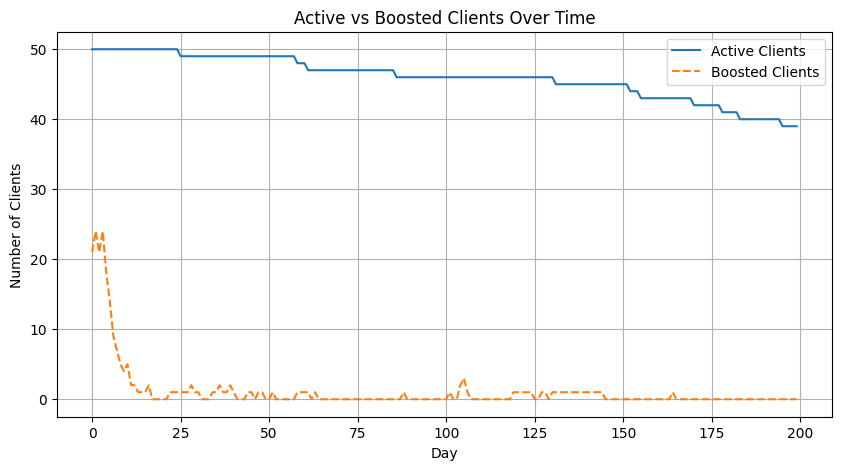

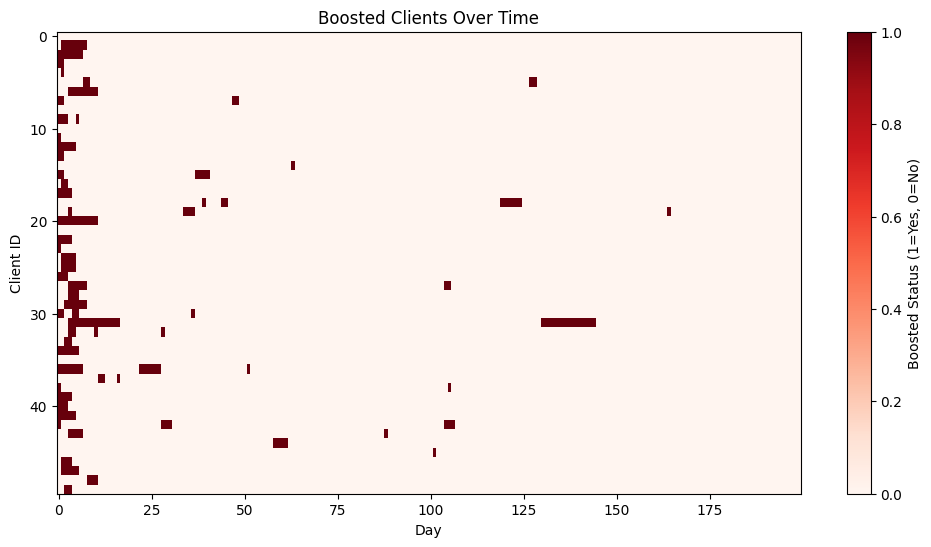

In [47]:
# Run simulation
rfq_df, active_history, activity_df, active_df, boosted_df = run_simulation()

# Plot active and boosted clients over time
plt.figure(figsize=(10,5))
plt.plot(active_df.sum(axis=1), label='Active Clients')
plt.plot(boosted_df.sum(axis=1), label='Boosted Clients', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Number of Clients')
plt.title('Active vs Boosted Clients Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Heatmap of boosted status
plt.figure(figsize=(12,6))
plt.imshow(boosted_df.T, aspect='auto', cmap='Reds')
plt.colorbar(label='Boosted Status (1=Yes, 0=No)')
plt.xlabel('Day')
plt.ylabel('Client ID')
plt.title('Boosted Clients Over Time')
plt.show()


In [ ]:
from scipy.special import betaln, gammaln
from scipy.optimize import minimize

# -----------------------------
#  Beta-Binomial mixture MLE with shared mean
# -----------------------------

def log_beta_binom_pmf(x, n, alpha, beta):
    # log [ C(n,x) * B(alpha+x, beta+n-x) / B(alpha,beta) ]
    return (
        gammaln(n + 1) - gammaln(x + 1) - gammaln(n - x + 1)
        + betaln(alpha + x, beta + n - x)
        - betaln(alpha, beta)
    )

def neg_log_likelihood(params, xs, ns):
    # params = [logit_mu, log_k_g, log_k_b, logit_qg]
    logit_mu, log_k_g, log_k_b, logit_qg = params
    
    mu = 1 / (1 + np.exp(-logit_mu))  # shared mean
    k_g = np.exp(log_k_g) + 1e-8
    k_b = np.exp(log_k_b) + 1e-8
    qg  = 1 / (1 + np.exp(-logit_qg))

    # convert to alpha, beta
    alpha_g, beta_g = mu * k_g, (1 - mu) * k_g
    alpha_b, beta_b = mu * k_b, (1 - mu) * k_b

    # mixture likelihood per client
    ll = []
    for x, n in zip(xs, ns):
        log_p_g = log_beta_binom_pmf(x, n, alpha_g, beta_g)
        log_p_b = log_beta_binom_pmf(x, n, alpha_b, beta_b)
        # log-sum-exp for mixture
        a = np.log(qg) + log_p_g
        b = np.log(1 - qg) + log_p_b
        m = max(a, b)
        ll_i = m + np.log(np.exp(a - m) + np.exp(b - m))
        ll.append(ll_i)
    return -np.sum(ll)

def fit_beta_mixture_mle(activity_df, train_days):
    """
    activity_df: (T x N) binary DataFrame
    train_days: number of days used for training (first half)
    Returns dict with fitted parameters.
    """
    T, N = activity_df.shape
    A = activity_df.iloc[:train_days].values  # (train_days x N)
    xs = A.sum(axis=0)  # successes per client in training
    ns = np.full_like(xs, fill_value=train_days)

    # rough start for mean
    p_hat = xs.mean() / train_days
    logit_mu0 = np.log(p_hat / (1 - p_hat + 1e-8))

    start = np.array([
        logit_mu0,
        np.log(10.0),   # k_g initial concentration
        np.log(2.0),    # k_b initial concentration
        0.0             # logit(0.5)
    ], dtype=float)

    res = minimize(neg_log_likelihood, start, args=(xs, ns), method='L-BFGS-B')
    logit_mu, log_k_g, log_k_b, logit_qg = res.x
    
    mu  = 1 / (1 + np.exp(-logit_mu))
    k_g = np.exp(log_k_g) + 1e-8
    k_b = np.exp(log_k_b) + 1e-8
    
    params = {
        'mu':     float(mu),
        'alpha_g': float(mu * k_g), 'beta_g': float((1 - mu) * k_g),
        'alpha_b': float(mu * k_b), 'beta_b': float((1 - mu) * k_b),
        'q_g':    float(1 / (1 + np.exp(-logit_qg))),
        'success': bool(res.success),
        'message': res.message
    }
    return params

def posterior_good(x, n, params):
    a_g = params['alpha_g']; b_g = params['beta_g']
    a_b = params['alpha_b']; b_b = params['beta_b']
    q_g = params['q_g']

    log_p_g = log_beta_binom_pmf(x, n, a_g, b_g)
    log_p_b = log_beta_binom_pmf(x, n, a_b, b_b)

    a = np.log(q_g) + log_p_g
    b = np.log(1 - q_g) + log_p_b
    m = max(a, b)
    num = np.exp(a - m)
    den = num + np.exp(b - m)
    return float(num / den)


In [90]:
# Fit on first half, removing first 25 days until it settles
T = activity_df.shape[0]
mid = T // 2
params = fit_beta_mixture_mle(activity_df[25:], train_days=mid)

# Detect abnormalities on second half using a sliding window
n_window = 10  # window size for detection, can be adjusted
threshold = 0.5  # classify as abnormal if p(good|D) < threshold

N = activity_df.shape[1]
abnormal_flags = np.zeros_like(activity_df.values, dtype=bool)

# For each day t in the second half, use the last n_window days (bounded within the second half)
for t in range(mid, T):
    start = max(mid, t - n_window + 1)
    end = t + 1
    window = activity_df.iloc[start:end].values  # (w x N)
    n = window.shape[0]
    x = window.sum(axis=0)
    # Posterior for each client
    p_good = np.array([posterior_good(int(xi), int(n), params) for xi in x])
    abnormal_flags[t, :] = p_good < threshold

abnormal_df = pd.DataFrame(abnormal_flags, columns=activity_df.columns, index=activity_df.index)


In [91]:
params

{'mu': 0.6459024041525655,
 'alpha_g': 17819.14219878137,
 'beta_g': 9768.837168102045,
 'alpha_b': 0.6772910514791353,
 'beta_b': 0.3713055277018204,
 'q_g': 0.892871535754001,
 'success': True,
 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}

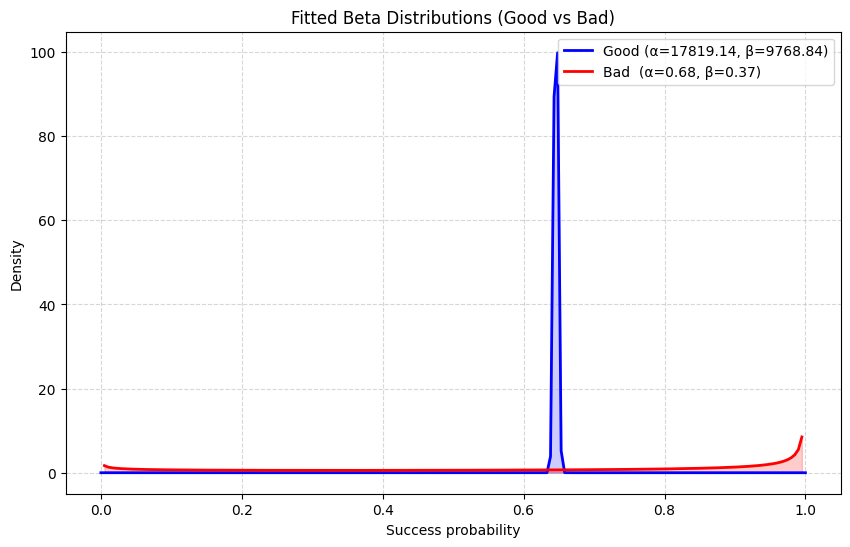

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_fitted_betas(params, bins=200):
    """
    Plot fitted good vs bad Beta distributions.
    params: dict returned by fit_beta_mixture_mle
    """
    a_g, b_g = params['alpha_g'], params['beta_g']
    a_b, b_b = params['alpha_b'], params['beta_b']
    q_g = params['q_g']

    # Grid
    x = np.linspace(0, 1, bins)

    # Densities
    pdf_g = beta.pdf(x, a_g, b_g)
    pdf_b = beta.pdf(x, a_b, b_b)

    plt.figure(figsize=(10, 6))
    plt.plot(x, pdf_g, label=f"Good (α={a_g:.2f}, β={b_g:.2f})", lw=2, color="blue")
    plt.plot(x, pdf_b, label=f"Bad  (α={a_b:.2f}, β={b_b:.2f})", lw=2, color="red")
    plt.fill_between(x, pdf_g, alpha=0.2, color="blue")
    plt.fill_between(x, pdf_b, alpha=0.2, color="red")

    plt.title("Fitted Beta Distributions (Good vs Bad)")
    plt.xlabel("Success probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, ls="--", alpha=0.5)
    plt.show()


plot_fitted_betas(params)

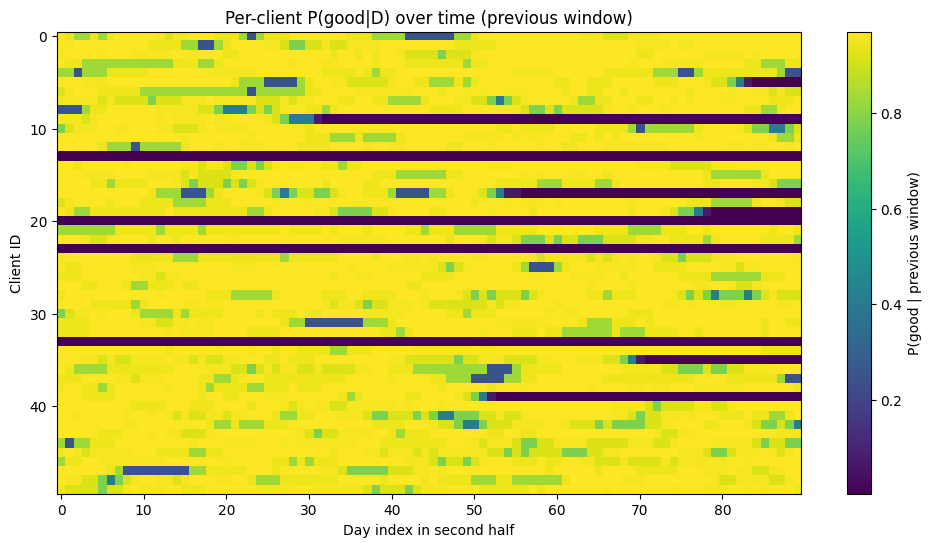

In [93]:
# Use a previous window (exclude day t) when computing P(good|D)
n_window = 10
threshold = 0.5

def build_pgood_panel(activity_df, boosted_df, active_df, params, mid, n_window, threshold):
    T, N = activity_df.shape
    rows = []
    # Start at mid + n_window to ensure a full *previous* window exists
    for t in range(mid + n_window, T):
        start = t - n_window
        end = t  # exclude day t
        window = activity_df.iloc[start:end]  # (n_window x N)
        x = window.sum(axis=0).values.astype(int)  # successes per client in previous window
        n = n_window
        # compute p_good for each client
        p_goods = []
        for j in range(N):
            p = posterior_good(int(x[j]), int(n), params)
            p_goods.append(p)
        p_goods = np.array(p_goods)
        # flags at time t
        boosted_t = boosted_df.iloc[t].values.astype(bool)
        active_t  = active_df.iloc[t].values.astype(bool)
        inactive_t = ~active_t
        traded_today = activity_df.iloc[t].values.astype(int)
        for j in range(N):
            rows.append({
                'day': t,
                'client_id': j,
                'x': int(x[j]),
                'n': int(n),
                'p_good': float(p_goods[j]),
                'abnormal': bool(p_goods[j] < threshold),
                'boosted': bool(boosted_t[j]),
                'inactive': bool(inactive_t[j]),
                'traded_today': int(traded_today[j])
            })
    panel = pd.DataFrame(rows)
    return panel

panel_df = build_pgood_panel(activity_df, boosted_df, active_df, params, mid, n_window, threshold)

# Correctly aligned daily summary for second half *with windowing*
days = sorted(panel_df['day'].unique())
daily_summary = panel_df.groupby('day').agg(
    abnormal_count=('abnormal', 'sum'),
    boosted_count=('boosted', 'sum'),
    inactive_count=('inactive', 'sum')
).reset_index()

# Overlap summary on client-day panel
overlap_summary = {
    'days_evaluated': int(len(days)),
    'clients': int(N),
    'total_client_days': int(panel_df.shape[0]),
    'abnormal_client_days': int(panel_df['abnormal'].sum()),
    'boosted_client_days': int(panel_df['boosted'].sum()),
    'inactive_client_days': int(panel_df['inactive'].sum()),
    'abnormal_and_boosted': int((panel_df['abnormal'] & panel_df['boosted']).sum()),
    'abnormal_and_inactive': int((panel_df['abnormal'] & panel_df['inactive']).sum()),
    'abnormal_not_boosted_or_inactive': int((panel_df['abnormal'] & ~panel_df['boosted'] & ~panel_df['inactive']).sum())
}
overlap_df2 = pd.DataFrame([overlap_summary])

# Heatmap of p_good by client (days x clients) for visual inspection
# Build a matrix with rows=days, cols=clients
days_idx = daily_summary['day'].values
pgood_mat = np.full((len(days_idx), N), np.nan)
for i, t in enumerate(days_idx):
    slice_t = panel_df[panel_df['day'] == t].sort_values('client_id')
    pgood_mat[i, :] = slice_t['p_good'].values

plt.figure(figsize=(12,6))
plt.imshow(pgood_mat.T, aspect='auto')
plt.colorbar(label='P(good | previous window)')
plt.xlabel('Day index in second half')
plt.ylabel('Client ID')
plt.title('Per-client P(good|D) over time (previous window)')
plt.show()

   

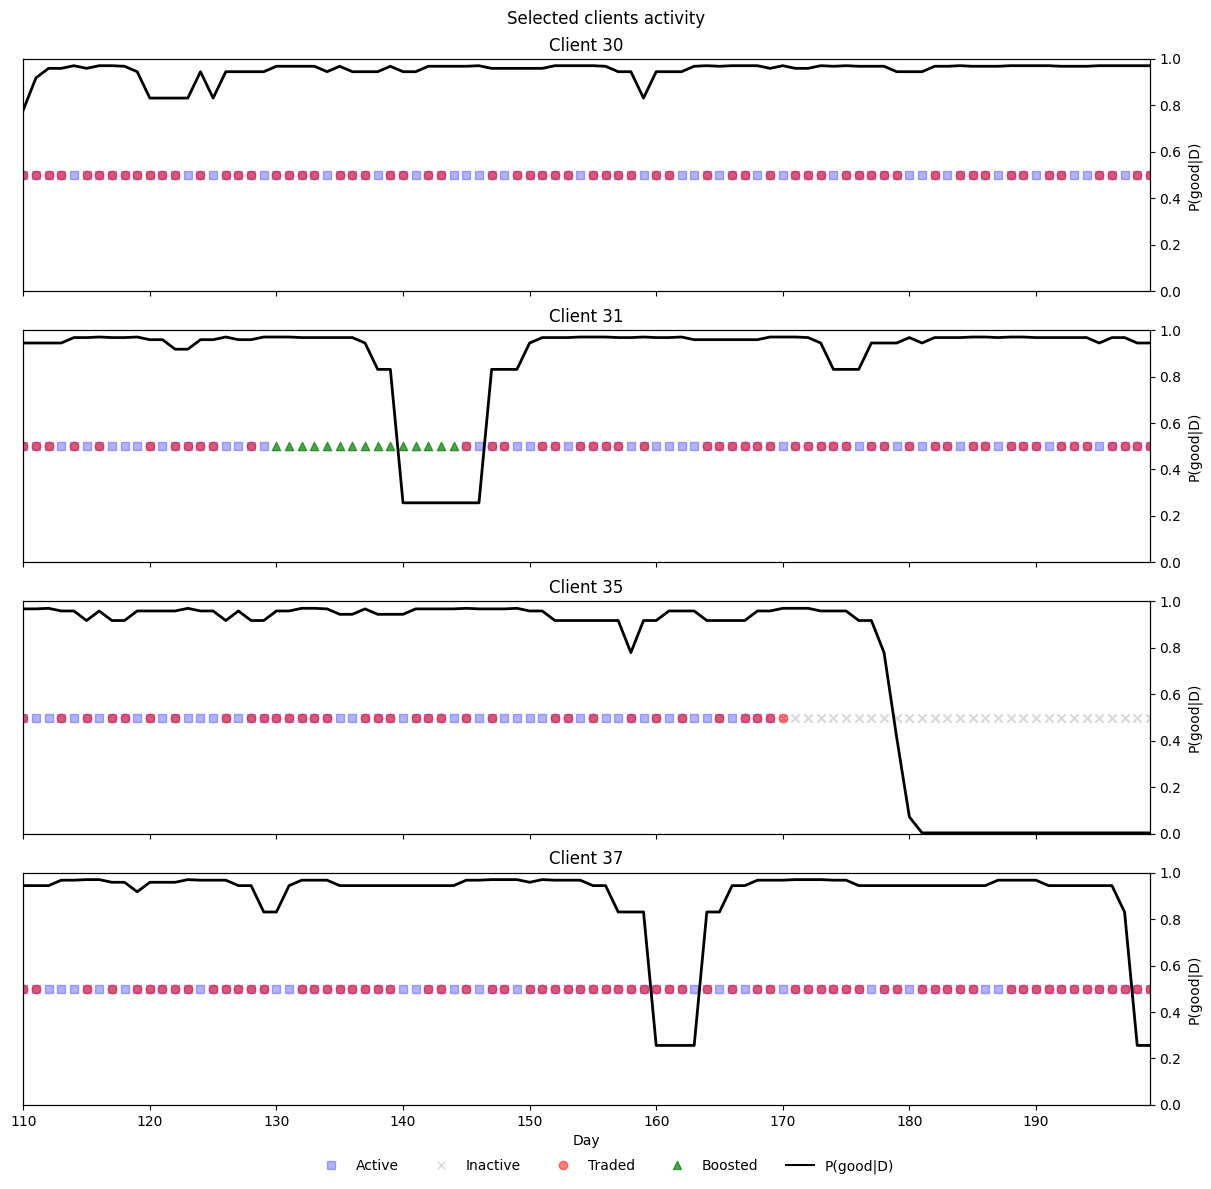

In [94]:
from matplotlib.lines import Line2D

def plot_clients_activity_prob(clients, df):
    """
    One figure with one row per client.
    On boosted days, only the 'Boosted' marker is shown (others hidden).
    """
    clients = list(clients)
    n = len(clients)
    if n == 0:
        return
    
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.8 * n), sharex=True, constrained_layout=True)
    if n == 1:
        axes = [axes]
    
    # Build a single, global legend
    legend_elems = [
        Line2D([0],[0], marker='s', linestyle='None', color='blue',  alpha=0.3, label='Active'),
        Line2D([0],[0], marker='x', linestyle='None', color='gray',  alpha=0.3, label='Inactive'),
        Line2D([0],[0], marker='o', linestyle='None', color='red',   alpha=0.5, label='Traded'),
        Line2D([0],[0], marker='^', linestyle='None', color='green', alpha=0.7, label='Boosted'),
        Line2D([0],[0], linestyle='-', color='black', label='P(good|D)'),
    ]
    
    x_min, x_max = None, None
    for ax, cid in zip(axes, clients):
        df_c = df[df['client_id'] == cid].sort_values('day').copy()
        if df_c.empty:
            ax.set_title(f"Client {cid} (no data)")
            ax.set_yticks([])
            continue
        
        # Masks
        boosted_mask  = df_c['boosted']
        active_mask   = (~df_c['inactive']) & (~boosted_mask)
        inactive_mask = df_c['inactive'] & (~boosted_mask)
        traded_mask   = (df_c['traded_today'] == 1) & (~boosted_mask)
        
        # Scatter statuses
        ax.scatter(df_c['day'][active_mask],   [1]*active_mask.sum(),   c='blue',  marker='s', alpha=0.3)
        ax.scatter(df_c['day'][inactive_mask], [1]*inactive_mask.sum(), c='gray',  marker='x', alpha=0.3)
        ax.scatter(df_c['day'][traded_mask],   [1]*traded_mask.sum(),   c='red',   marker='o', alpha=0.5)
        ax.scatter(df_c['day'][boosted_mask],  [1]*boosted_mask.sum(),  c='green', marker='^', alpha=0.7, zorder=3)
        
        ax.set_yticks([])
        ax.set_ylim(0.5, 1.5)
        
        # p_good
        ax2 = ax.twinx()
        ax2.plot(df_c['day'], df_c['p_good'], color='black', lw=2)
        ax2.set_ylim(0, 1)
        ax2.set_ylabel("P(good|D)")
        
        ax.set_title(f"Client {cid}")
        
        # Track x-lims
        dmin, dmax = df_c['day'].min(), df_c['day'].max()
        x_min = dmin if x_min is None else min(x_min, dmin)
        x_max = dmax if x_max is None else max(x_max, dmax)
    
    axes[-1].set_xlabel("Day")
    if x_min is not None and x_max is not None:
        axes[-1].set_xlim(x_min, x_max)
    
    fig.suptitle("Selected clients activity", y=1.02)
    
    # Move legend below figure
    fig.legend(handles=legend_elems, loc='lower center', ncol=5, frameon=False, bbox_to_anchor=(0.5, -0.03))
    plt.show()


plot_clients_activity_prob([30,31,35, 37], panel_df)


In [101]:
from sklearn.metrics import confusion_matrix

def _cm_df(cm, labels=("Pred 0", "Pred 1"), index=("True 0", "True 1")):
    """Pretty dataframe for a 2x2 confusion matrix."""
    return pd.DataFrame(cm, index=index, columns=labels)

def evaluate_confusions(panel_df, normalize=False):
    """
    Evaluate confusion matrices without recomputing thresholds.

    Uses:
      - df['abnormal'] as the model's predicted abnormal label (already thresholded).
      - df['inactive'] and df['boosted'] as operational labels.
      - Global abnormality = (inactive OR boosted).

    Returns dict with both raw arrays and pretty DataFrames.
    Set normalize=True to return per-true-class rates instead of counts.
    """
    df = panel_df.copy()

    # Ensure ints
    y_abnormal = df["abnormal"].astype(int).values
    y_inactive = df["inactive"].astype(int).values
    y_boosted  = df["boosted"].astype(int).values

    # Global abnormality (prediction-side for the overall CM)
    y_global_abn = (df["inactive"] | df["boosted"]).astype(int).values

    # Normalization mode for sklearn
    norm_mode = "true" if normalize else None

    results = {}

    # 1) Inactive (truth) vs Abnormal (model)
    cm_inactive = confusion_matrix(y_inactive, y_abnormal, labels=[0,1], normalize=norm_mode)
    results["inactive_vs_abnormal"] = cm_inactive
    results["inactive_vs_abnormal_df"] = _cm_df(cm_inactive)

    # 2) Boosted (truth) vs Abnormal (model)
    cm_boosted = confusion_matrix(y_boosted, y_abnormal, labels=[0,1], normalize=norm_mode)
    results["boosted_vs_abnormal"] = cm_boosted
    results["boosted_vs_abnormal_df"] = _cm_df(cm_boosted)

    # 3) OVERALL: Abnormal (truth) vs Global abnormality (prediction = inactive OR boosted)
    cm_overall = confusion_matrix(y_abnormal, y_global_abn, labels=[0,1], normalize=norm_mode)
    results["overall_abnormal_vs_global"] = cm_overall
    results["overall_abnormal_vs_global_df"] = _cm_df(cm_overall)

    return results

# Example usage:
cm_results = evaluate_confusions(panel_df, normalize=False)
print("Inactive (truth) vs Abnormal (model):\n", cm_results["inactive_vs_abnormal_df"], "\n")
print("Boosted (truth) vs Abnormal (model):\n", cm_results["boosted_vs_abnormal_df"], "\n")
print("Overall: Abnormal (truth) vs Global (inactive OR boosted) prediction:\n", cm_results["overall_abnormal_vs_global_df"])


Inactive (truth) vs Abnormal (model):
         Pred 0  Pred 1
True 0    3830      74
True 1      56     540 

Boosted (truth) vs Abnormal (model):
         Pred 0  Pred 1
True 0    3867     609
True 1      19       5 

Overall: Abnormal (truth) vs Global (inactive OR boosted) prediction:
         Pred 0  Pred 1
True 0    3811      75
True 1      69     545
